### Machine Learning for Finance with Python

First we will import the packages.

In [0]:
import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

Next we will load the data.

In [0]:
spy_df = pd.read_csv('https://assets.datacamp.com/production/repositories/\
2168/datasets/0e72705a29abc4ad16fd29acd0304570ea27111e/SPY.csv',
parse_dates=['Date'],index_col='Date')

In [3]:
spy_df.head()

,Adj_Close,Adj_Volume
Date,,
1993-01-29,28.223927,1003200.0
1993-02-01,28.424666,480500.0
1993-02-02,28.484856,201300.0
1993-02-03,28.785997,529400.0
1993-02-04,28.906440,531500.0


In [0]:
lng_df = pd.read_csv("https://assets.datacamp.com/production/repositories/2168/\
datasets/b1c089b35aa59a7290964640af811125f74fe3ec/LNG.csv",
parse_dates=['Date'],index_col='Date')

In [5]:
lng_df.head()

,Adj_Close,Adj_Volume
Date,,
1994-04-04,72.0,0.0
1994-04-05,108.0,0.0
1994-04-06,108.0,0.0
1994-04-07,108.0,0.0
1994-04-08,108.0,0.0


We will only keep data for year 2016 and above.

In [0]:
lng_df = lng_df['2016':]
spy_df = spy_df['2016':]

Plot the adjusted closing price data.

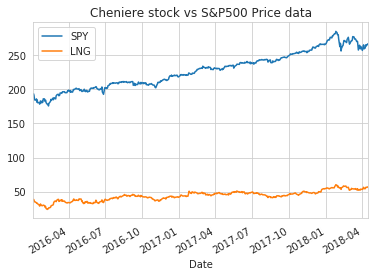

In [7]:
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True)
plt.title('Cheniere stock vs S&P500 Price data')
plt.legend(loc=2);

Plotting the percent change data. We will plot the histogram with 50 bins.

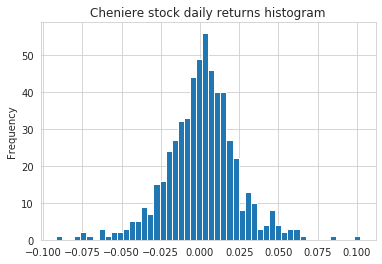

In [8]:
lng_df['Adj_Close'].pct_change().plot.hist(bins = 50)
plt.title('Cheniere stock daily returns histogram');

Correlations

Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. 

Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is mean-reverting (bounces around) or trend-following (goes up if it has been going up recently).

Create a 5-day percent change of Adj Close, for current day and 5 days in the future.

In [0]:
lng_df['5d'] = lng_df['Adj_Close'].shift(-5)

In [10]:
lng_df.head(10)

,Adj_Close,Adj_Volume,5d
Date,,,
2016-01-04,37.51,2246475.0,33.79
2016-01-05,38.47,2903163.0,33.47
2016-01-06,37.06,2098817.0,32.59
2016-01-07,34.97,3473839.0,32.81
2016-01-08,35.01,1920189.0,32.00
2016-01-11,33.79,4837772.0,30.01
2016-01-12,33.47,4641517.0,28.52
2016-01-13,32.59,6059485.0,29.13
2016-01-14,32.81,3657654.0,31.62


In [0]:
# Creating a percent change column 5 days into the future.

lng_df['5d_future_returns'] = lng_df['5d'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

In [12]:
lng_df.head(10)

,Adj_Close,Adj_Volume,5d,5d_future_returns,5d_close_pct
Date,,,,,
2016-01-04,37.51,2246475.0,33.79,NaN,NaN
2016-01-05,38.47,2903163.0,33.47,NaN,NaN
2016-01-06,37.06,2098817.0,32.59,NaN,NaN
2016-01-07,34.97,3473839.0,32.81,NaN,NaN
2016-01-08,35.01,1920189.0,32.00,NaN,NaN
2016-01-11,33.79,4837772.0,30.01,-0.111867,-0.099174
2016-01-12,33.47,4641517.0,28.52,-0.147894,-0.129971
2016-01-13,32.59,6059485.0,29.13,-0.106168,-0.120615
2016-01-14,32.81,3657654.0,31.62,-0.036269,-0.061767


Calculate the correlation matrix between the 5d close pecentage changes (current and future)


In [0]:
corr = lng_df[['5d_future_returns', '5d_close_pct']].corr()

In [14]:
corr.iloc[0][1]

0.04786077952678092

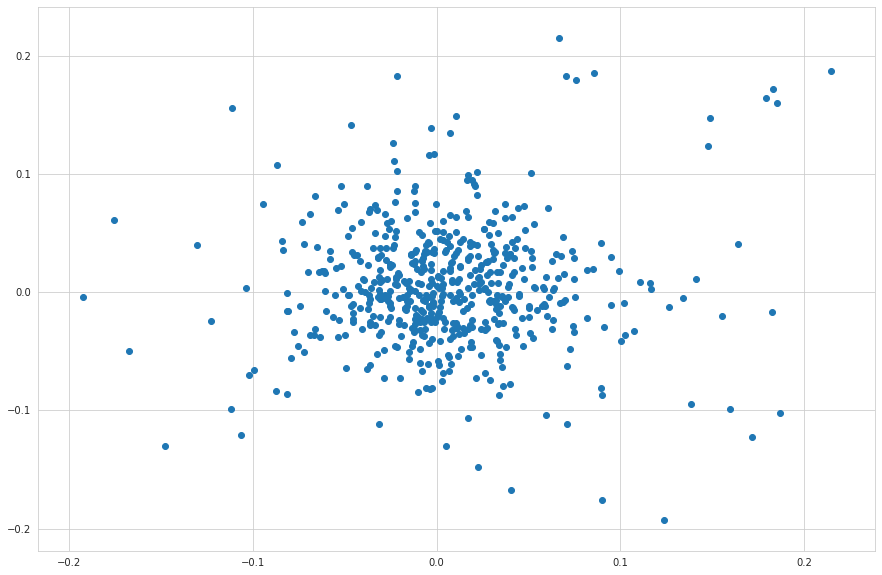

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(lng_df['5d_future_returns'], lng_df['5d_close_pct']);

We can see there doesn't seem to be much correlation between these two results.

Next we will create features and labels for our data.

Creating features and Targets.

- Features
    - Moving Average
    - RSI
    
- Target
    - 5 Day Close percent change

In [0]:
feature_names = ['5d_close_pct']

# Creating a Moving Averge
# and RSI for 14, 30, 50 and 200 period

arr = np.array([14,30,50,200])

for n in arr:

  lng_df['ma_' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                                     timeperiod = n)
  
  lng_df['rsi_' + str(n)] = talib.RSI(lng_df['Adj_Close'].values,
                                      timeperiod = n)
  
  feature_names = feature_names + ['ma_' + str(n),
                                   'rsi_' + str(n)]

In [17]:
print(feature_names)

['5d_close_pct', 'ma_14', 'rsi_14', 'ma_30', 'rsi_30', 'ma_50', 'rsi_50', 'ma_200', 'rsi_200']


We have our labels and features.

We need to drop any `NA` values. We can see the `NA` values below.

In [18]:
lng_df.isna().sum()

Adj_Close              0
Adj_Volume             0
5d                     5
5d_future_returns      5
5d_close_pct           5
ma_14                 13
rsi_14                14
ma_30                 29
rsi_30                30
ma_50                 49
rsi_50                50
ma_200               199
rsi_200              200
dtype: int64

In [0]:
lng_df.dropna(inplace=True)

We will separate our features and targets.

In [0]:
features = lng_df[feature_names]
targets = lng_df['5d_future_returns']

Create DataFrame from target column and feature columns

In [0]:
feature_and_target_columns = feature_names + ['5d_future_returns']

feat_targ_df = lng_df[feature_and_target_columns]

In [22]:
corr = feat_targ_df.corr()
print(corr)

                   5d_close_pct     ma_14  ...   rsi_200  5d_future_returns
5d_close_pct           1.000000 -0.082642  ...  0.300738          -0.033087
ma_14                 -0.082642  1.000000  ...  0.782841          -0.136905
rsi_14                 0.687162  0.210005  ...  0.648441          -0.042130
ma_30                 -0.117420  0.965293  ...  0.664793          -0.128291
rsi_30                 0.533761  0.430826  ...  0.835123          -0.096066
ma_50                 -0.127178  0.896181  ...  0.534482          -0.122722
rsi_50                 0.446073  0.551553  ...  0.924822          -0.135744
ma_200                -0.008986  0.769015  ...  0.368278          -0.001820
rsi_200                0.300738  0.782841  ...  1.000000          -0.197180
5d_future_returns     -0.033087 -0.136905  ... -0.197180           1.000000

[10 rows x 10 columns]


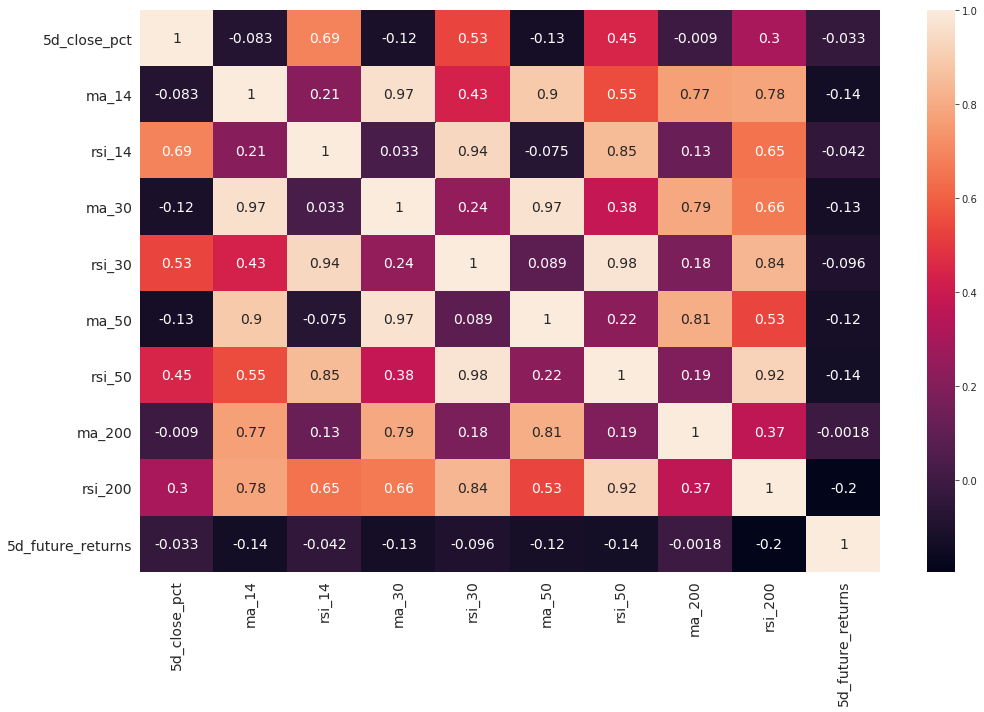

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, annot_kws={'size':14})
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14) 
plt.tight_layout()
plt.show();

Create train and test features

In [0]:
from sklearn.model_selection import train_test_split

We will split the data and keep 75% for training and 25% for testing.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.35)

We will apply the `RandomForestRegressor`

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [28]:
print(f"The Training model score is : {np.round(forest.score(X_train, y_train),2)}") 

The Training model score is : 0.94


In [29]:
print(f"The Training model score is : {np.round(forest.score(X_test, y_test),2)}")

The Training model score is : 0.67


We can see that our test score is way lower than the training score. We might be underfitting the model.